In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
    

In [13]:

# Cargar datos
df = pd.read_csv("../data/raw/Aquifer_Petrignano.csv")
df = df[df['Rainfall_Bastia_Umbra'].notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature',
              'drainage_volume', 'river_hydrometry']
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Reemplazar ceros por NaN en algunas columnas
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

# Interpolación y resampleo semanal
df = df.interpolate()
df = df.set_index('date').resample('7D').mean().reset_index()
    

In [14]:

# Test de estacionariedad
adf_result = adfuller(df['depth_to_groundwater'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
    

ADF Statistic: -2.8802016493166587
p-value: 0.04769919092020904


ARIMA MAE: 1.2003552482840452
ARIMA RMSE: 1.4025336271849616


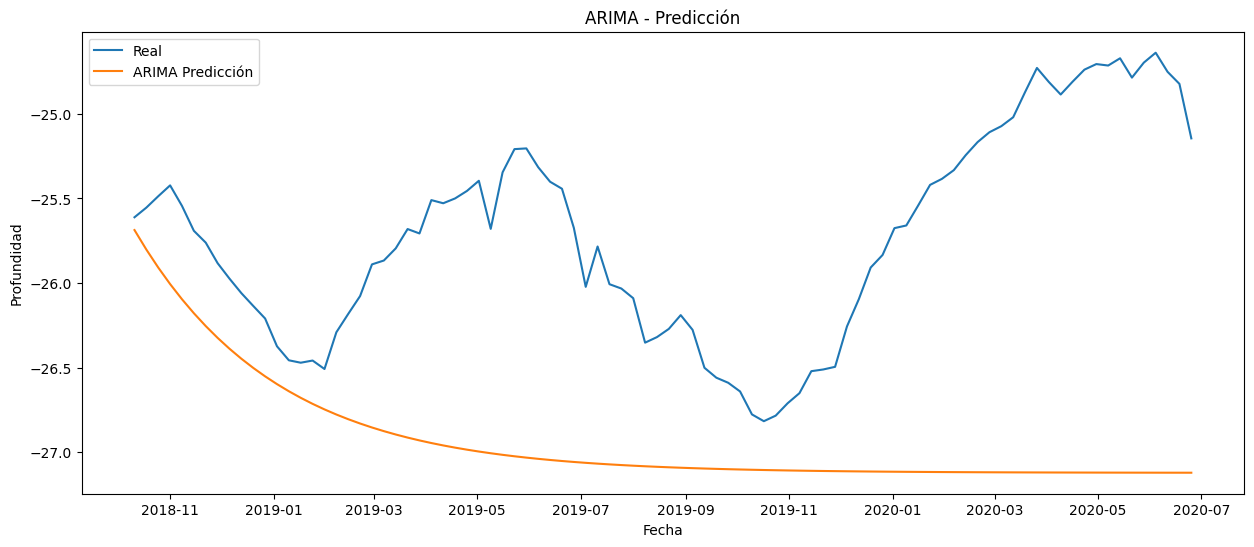

In [15]:

# Modelo ARIMA
train_size = int(len(df) * 0.85)
arima_series = df['depth_to_groundwater']
train_arima = arima_series[:train_size]
test_arima = arima_series[train_size:]

model_arima = ARIMA(train_arima, order=(1, 1, 1))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test_arima))

# Métricas ARIMA
mae_arima = mean_absolute_error(test_arima, forecast_arima)
rmse_arima = math.sqrt(mean_squared_error(test_arima, forecast_arima))
print(f"ARIMA MAE: {mae_arima}")
print(f"ARIMA RMSE: {rmse_arima}")

# Visualización ARIMA
plt.figure(figsize=(15,6))
plt.plot(df['date'][train_size:], test_arima, label='Real')
plt.plot(df['date'][train_size:], forecast_arima, label='ARIMA Predicción')
plt.title('ARIMA - Predicción')
plt.xlabel('Fecha')
plt.ylabel('Profundidad')
plt.legend()
plt.show()
    

In [16]:

# Preparación de datos para LSTM
data = df.filter(['depth_to_groundwater'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

look_back = 12
train = scaled_data[:train_size]
test = scaled_data[train_size - look_back:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    

In [17]:

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=10, validation_data=(x_test, y_test))
    

Epoch 1/10


c:\Users\david\anaconda3\envs\entorno\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0197 - val_loss: 0.0020
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - val_loss: 4.4236e-04
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8260e-04 - val_loss: 3.5599e-04
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1218e-04 - val_loss: 4.5576e-04
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2275e-04 - val_loss: 3.6385e-04
Epoch 6/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4056e-04 - val_loss: 1.7710e-04
Epoch 7/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8214e-04 - val_loss: 1.9182e-04
Epoch 8/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5757e-04 - val_loss: 0.0019
Epoch 9/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0255e-04 - val_loss: 1.2374e-04
Epoch 10/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0117e-04 - val_loss: 1.3175e-04


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM MAE: 0.1266181805323039
LSTM RMSE: 0.16610668776355972


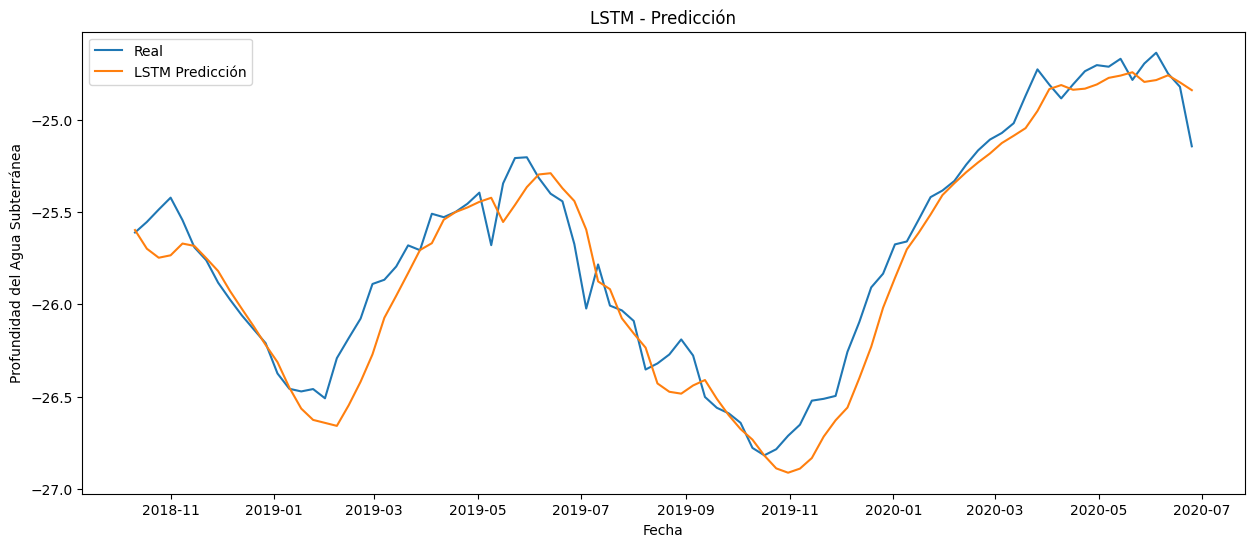

In [18]:

# Predicciones LSTM
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

rmse_lstm = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
mae_lstm = mean_absolute_error(y_test[0], test_predict[:,0])
print(f"LSTM MAE: {mae_lstm}")
print(f"LSTM RMSE: {rmse_lstm}")

# Visualización
test_dates = df['date'][-len(y_test[0]):]

plt.figure(figsize=(15,6))
plt.plot(test_dates, y_test[0], label='Real')
plt.plot(test_dates, test_predict[:,0], label='LSTM Predicción')
plt.title('LSTM - Predicción')
plt.xlabel('Fecha')
plt.ylabel('Profundidad del Agua Subterránea')
plt.legend()
plt.show()
    

In [19]:

# Comparativa
results = pd.DataFrame({
    'Modelo': ['ARIMA', 'LSTM'],
    'MAE': [mae_arima, mae_lstm],
    'RMSE': [rmse_arima, rmse_lstm]
})
results
    

,Modelo,MAE,RMSE
0,ARIMA,1.200355,1.402534
1,LSTM,0.126618,0.166107


ARIMA

MAE = 1.20 y RMSE = 1.40 indican errores bastante elevados.

Esto sugiere que el modelo no capta bien la dinámica no lineal de la serie temporal.

ARIMA es bueno para patrones lineales y estacionarios, pero se queda corto cuando hay estacionalidad compleja o relaciones no lineales.

LSTM

MAE = 0.13, RMSE = 0.17 → una mejora brutal.

LSTM es muy buena para capturar patrones temporales complejos, incluso cuando hay ruido, lags, o relaciones no evidentes.

La mejora frente a ARIMA es de más del 85% en error absoluto.

El LSTM ha aprendido mucho mejor la evolución de la profundidad del agua subterránea.